In [144]:
import frgtools.misc as frgm
import frgtools.xrd as xrd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
# style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from tqdm import tqdm_notebook as tqdm

In [145]:
# from importlib import reload
# reload(xrd)

<module 'frgtools.xrd' from '/Users/rishi/Documents/GitHub/Python-Utilities/FrgTools/frgtools/xrd.py'>

# Loading Raw Data File

In [3]:
fids = frgm.listdir('Data')

Files in 'Data':
0:KPbF3.ras
1:CsPbSnF3_50_5isl.ras
2:CsPbSnF3_25.ras
3:CsPbF3_AF.ras
4:CsPbSnF3_50.ras
5:KPbF3_fast.ras
6:CsPbF3_B_NK.ras
7:CsPbSnF3_75.ras
8:CsPbSnF3_25_5isl.ras
9:RbPbF3.ras
10:CsPbF3_AF_nK.ras
11:CsPbF3.ras


In [4]:
dfData = {}

for idx, f in enumerate(fids):
    tempdata = xrd.load_smartlab(f)
    del(tempdata['header']) #assumes we dont need the header for following analyses
                            # some tool parameters in here are important to keep track of ie step size, and res
                            # will make repeating sucessful scans easy
    
    if idx == 0: #on first pass, initialize keys for each data entry in the dataframe dictionary
        for k, v in tempdata.items():
            dfData[k] = [v]
    else:  #on subsequent passes, append new lines of data to dataframe dictionary
        for k, v in tempdata.items():
            dfData[k].append(v)      

df = pd.DataFrame(dfData)

In [46]:
# df.head() #.head() only displays the 5 first rows of your dataframe, its a safe way of peeking at the data without rendering a potentially massive table

In [148]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = 'Cs'
Filter_2 = ''
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
for n in df_filter3['name'].unique(): print(n)

CsPbSnF3_50_5isl
CsPbSnF3_25
CsPbF3_AF
CsPbSnF3_50
CsPbF3_B_NK
CsPbSnF3_75
CsPbSnF3_25_5isl
CsPbF3_AF_nK
CsPbF3


## Looking at selected plots preprocessed

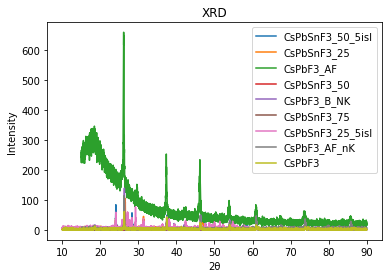

In [151]:
# filtered DataFrame to Plot
DF = df_filter3

# single
# q = 3
# plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=DF['name'][q])

# multiple:
for q in range (len(DF)):
    plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=DF['name'][q])

plt.legend()
plt.title('XRD')
# plt.ylim(0,25)
# plt.xlim(0,1.2)

plt.ylabel('Intensity')
plt.xlabel('2θ')
plt.show()

## Remove Background

In [146]:
df['counts_bgremoved'] = df.apply(lambda x: xrd.remove_background(x.angles,x.counts), axis=1)

## Normalizng All XRD Data

In [154]:
def normalizeCounts(x):
    return (x-x.min()) / (x.max() - x.min())
df['counts_norm'] = df['counts_bgremoved'].apply(normalizeCounts) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

## Noise Filtering

REK Note: just need to be careful about smoothing with XRD data. Most (all?) smoothing filters will introduce some level of peak broadening depending on the window length chosen, and peak heights will likely be decreased as well. Potentially risky to include in default preprocessing for refinement, where peak width/heights are crucial. the refinement itself should essentially be peak fitting and compensate for some noise on its own.

In [155]:
from functools import partial #https://docs.python.org/2/library/functools.html

#savgol_filter to smooth the data
df['counts_f1'] = df['counts_norm'].apply(
    partial(savgol_filter, window_length = 15, polyorder = 3)
)

## Peak Indexing, takes a few seconds

In [156]:
df['peak_index'] = tqdm(df['counts_f1'].apply(
    partial(find_peaks_cwt, widths = np.arange(10,15), noise_perc = 0.02)
))

In [157]:
def peakAngles(row):
    angles = [row['angles'][idx] for idx in row['peak_index']]
    return np.asarray(angles)

df['peak_angle'] = df.apply(peakAngles, axis = 1)

## Peak Intensity

In [158]:
def peakIntensity(row):
    peakI = [row['counts_f1'][idx] for idx in row['peak_index']]
    return np.asarray(peakI)

df['peak_intensity'] = df.apply(peakIntensity, axis = 1)

### Now Refiltering to Interested Samples

In [159]:
Filter_1 = 'Cs'
Filter_2 = 'AF'
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)
for n in df_filter3['name'].unique(): print(n)

CsPbF3_AF
CsPbF3_AF_nK


### Now Plotting Processed Data

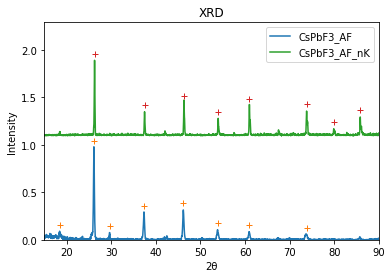

In [175]:
# filtered DataFrame to Plot
DF = df_filter3

# plotting single use:
# q = 3
# #masking out bad peaks
# a = DF['Peak_Intensity'][q]
# a = np.ma.masked_where(a <= 0.005 , a)

#plotting
# plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts_f1'], label=DF['name'][q])
# plt.plot(DF['Peak_Angle'][q],a+.05,'+')

# plotting multiple use:

min_intensity = 0.05

# for q in range(len(DF)):
#     #masking out bad peaks
#     a = DF['peak_intensity'][q]
#     a = np.ma.masked_where(a <= min_intensity , a)
    
#     #plotting
#     plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts_f1']+q*1.1, label=DF['name'][q])
#     plt.plot(DF['peak_angle'][q],a+0.05+q*1.2,'+')


for q, (_, r) in enumerate(DF.iterrows()):
    #mask out low intensity peaks
    a = r['peak_intensity']
    a = np.ma.masked_where(a <= min_intensity, a)
    
    #plotting
    plt.plot(r['angles'], r['counts_f1'] + q*1.1, label = r['name'])
    plt.plot(r['peak_angle'], a + 0.07 + q*1.1, '+')

plt.legend()
plt.title('XRD')
plt.ylim(0,max(DF.loc[q]['counts_f1']+1.5))
plt.xlim(min(DF.loc[q]['angles']),max(DF.loc[q]['angles']))

plt.ylabel('Intensity')
plt.xlabel('2θ')
plt.show()

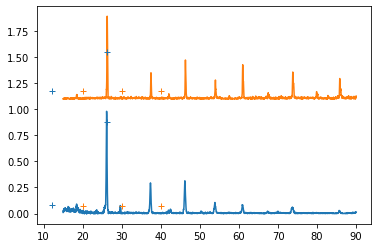

In [185]:
materials = {
    'PbI2': [12.1, 26.2],
    'CsPbBr3': [20, 30, 40]
}

for q, (_, r) in enumerate(DF.iterrows()):
    #mask out low intensity peaks
    a = r['peak_intensity']
    a = np.ma.masked_where(a <= min_intensity, a)
    
    #plotting
    plt.plot(r['angles'], r['counts_f1'] + q*1.1, label = r['name'])
#     plt.plot(r['peak_angle'], a + 0.07 + q*1.1, '+')
    
    xlim0 = plt.xlim()
    for midx, (material, peaks) in enumerate(materials.items()):
        for p in peaks:
            if p > xlim0[0] and p < xlim0[1]:
                idx = np.argmin(np.abs(r['angles'] - p))
                plt.plot(p, r['counts_f1'][idx] + 0.07 + q*1.1, '+', color = plt.cm.tab10(midx))

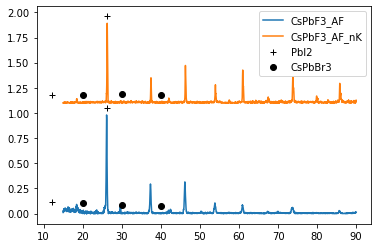

In [213]:
materials = {
    'PbI2': [12.1, 26.2],
    'CsPbBr3': [20, 30, 40]
}

label = None
for q, (_, r) in enumerate(DF.iterrows()):
    #mask out low intensity peaks
    a = r['peak_intensity']
    a = np.ma.masked_where(a <= min_intensity, a)

    #plotting
    plt.plot(r['angles'], r['counts_f1'] + q*1.1, label = r['name'])
#     plt.plot(r['peak_angle'], a + 0.07 + q*1.1, '+')

    xlim0 = plt.xlim()
    
    symbollist = ['+', 'o', 'square']
    for midx, (material, peaks) in enumerate(materials.items()):
        if q == DF.shape[0]-1:
            label = material
        for p in peaks:
            if p > xlim0[0] and p < xlim0[1]:
                idx = np.argmin(np.abs(r['angles'] - p))
                idxmin = np.max([0, idx-20])
                idxmax = np.min([idx+20, len(r['angles'])-1])
                y = np.max(r['counts_f1'][idxmin:idxmax])
#                 y = r['counts_f1'][idx]
                plt.plot(p, y + 0.07 + q*1.1, '+', color = 'k', marker = symbollist[midx], label = label)
                label = None
    plt.legend()
                    


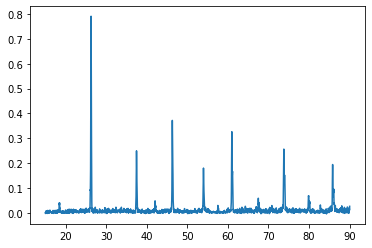

In [188]:
x = r['angles']
y = r['counts_f1']

plt.plot(x,y)

In [197]:
np.argmin(np.abs(x - 26))

1100

In [192]:
x[1100]

26.0

In [193]:
y[1100]

0.01588024505750126